In [1]:
import numpy as np
import pandas as pd
import gensim
import random

import matplotlib.pyplot as plt
from tcn import TCN
from sklearn.model_selection import train_test_split

from keras.optimizers import Adam

Using TensorFlow backend.


### Load, preprocess and clean dataset - SKIP THIS

In [ ]:
def load_dataset(path):
    dataset = pd.read_csv('./data/training_set_rel3.tsv', sep='\t', encoding = "ISO-8859-1")
    df_by_essay_set = list(dataset.groupby('essay_set'))
    
    scores = np.array([])
    essays = np.array([])
    for set_id in range(1,len(df_by_essay_set)):
        domain1_score = df_by_essay_set[set_id][1]['domain1_score'].values
        domain2_score = df_by_essay_set[set_id][1]['domain2_score'].values
        set_essays = df_by_essay_set[set_id][1]['essay'].values

        domain1_score_norm = (domain1_score - domain1_score.min()) / (domain1_score.max() - domain1_score.min())
        domain2_score_norm = (domain2_score - domain2_score.min()) / (domain2_score.max() - domain2_score.min())

        #total_score = np.nanmean([domain1_score_norm, domain2_score_norm], axis=0)
        total_score = np.nanmean([domain1_score_norm], axis=0)

        scores = np.concatenate([scores, total_score])
        essays = np.concatenate([essays, set_essays])
        
    assert scores.max() == 1.0 and scores.min() == 0.0
    return essays, scores

In [ ]:
X, y = load_dataset('./data/training_set_rel3.tsv')

(array([ 445.,    5.,   24.,  657.,  111., 1323., 1057., 1287.,  257.,
        1198., 1563., 1489.,  255.,   64., 1458.]),
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
        1.        ]),
 <a list of 15 Patch objects>)

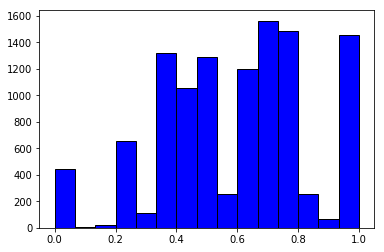

In [8]:
# Distribution of grades
plt.hist(y, color = 'blue', edgecolor = 'black', bins = 15)

In [9]:
filepath = "./GoogleNews-vectors-negative300.bin"

embeddings_index = {}
from gensim.models import KeyedVectors
wv_from_bin = KeyedVectors.load_word2vec_format(filepath, binary=True) 
for word, vector in zip(wv_from_bin.vocab, wv_from_bin.vectors):
    coefs = np.asarray(vector, dtype='float32')
    embeddings_index[word] = coefs

In [11]:
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec

def essay_to_wordlist(essay_v, remove_stopwords):
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences += (essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

In [ ]:
X = []
for essay in essays:
    X.append(essay_to_sentences(essay, remove_stopwords = True))

In [12]:
import difflib
from nltk.corpus import words
from spellchecker import SpellChecker
from tqdm import tqdm

def process(x):
        spell = SpellChecker()
        x_n = []
        for w in x:
            try:
                x_n.append(embeddings_index[w])
            except KeyError:
                try:
                    w_2 = spell.correction(w)
                    x_n.append(embeddings_index[w_2])
                except:
                    #print('WARNING: Cant find word %s' % w_2)
                    pass
        return x_n

In [ ]:
# NOTE: This takes A LOT of time, rather load the pre_made
from multiprocessing import Pool
pool = Pool(processes=4)
X_np = pool.map(process, X)

In [ ]:
#np.save('./X.npy', np.array(X_np))
#np.save('./y.npy', y)

### LOAD the cleaned dataset

In [ ]:
X = np.load("./X.npy")
y = np.load("./y.npy")

In [ ]:
# Reshape and expand
X = list(map(lambda x: np.array(x), X))
X = list(map(lambda x: x.reshape(1, x.shape[0], x.shape[1]), X))
y = np.expand_dims(y, axis=-1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train Model

#### Model 1 - TCN

In [231]:
from keras.layers import Dense
from keras.models import Input, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from tcn import compiled_tcn
from tcn import TCN

batch_size, input_dim = None, 300

i = Input(batch_shape=(1, None, 300))
o = TCN(nb_filters=24, 
        kernel_size=8, 
        nb_stacks=4, 
        dilations=[2 ** i for i in range(7)], 
        activation='norm_relu', 
        padding='causal', 
        use_skip_connections=True, 
        dropout_rate=0.1, 
        return_sequences=False, 
        name='tcn')(i)
o = Dense(30, activation='softmax')(o)
o = Dense(1, activation='sigmoid')(o)
model = Model(inputs=[i], outputs=[o])

In [232]:
adam = Adam(lr=0.0001)
model.compile(adam, loss='mean_squared_error')

In [233]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           (1, None, 300)       0                                            
__________________________________________________________________________________________________
tcn_initial_conv (Conv1D)       (1, None, 24)        7224        input_46[0][0]                   
__________________________________________________________________________________________________
tcn_d_causal_conv_1_tanh_s0 (Co (1, None, 24)        4632        tcn_initial_conv[0][0]           
__________________________________________________________________________________________________
activation_677 (Activation)     (1, None, 24)        0           tcn_d_causal_conv_1_tanh_s0[0][0]
__________________________________________________________________________________________________
lambda_674

In [234]:
epochs = 100

from itertools import cycle
train_data = cycle(zip(X_train, y_train))
validation_data = cycle(zip(X_test, y_test))

In [235]:
checkpoint = ModelCheckpoint('./models/model-tcn-{epoch:03d}.h5', verbose=0, monitor='val_loss', save_best_only=True, mode='min')
stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')

In [236]:
history = model.fit_generator(iter(train_data), epochs=epochs, steps_per_epoch=1000, max_queue_size=1, validation_data=iter(validation_data), validation_steps=500, callbacks=[checkpoint, stopping])

Epoch 1/100
1000/1000 [==============================] - 157s 157ms/step - loss: 0.0557 - val_loss: 0.0485
Epoch 2/100
1000/1000 [==============================] - 117s 117ms/step - loss: 0.0452 - val_loss: 0.0509
Epoch 3/100
1000/1000 [==============================] - 117s 117ms/step - loss: 0.0475 - val_loss: 0.0426
Epoch 4/100
1000/1000 [==============================] - 117s 117ms/step - loss: 0.0457 - val_loss: 0.0470
Epoch 5/100
1000/1000 [==============================] - 117s 117ms/step - loss: 0.0474 - val_loss: 0.0405
Epoch 6/100
1000/1000 [==============================] - 117s 117ms/step - loss: 0.0463 - val_loss: 0.0480
Epoch 7/100
1000/1000 [==============================] - 116s 116ms/step - loss: 0.0442 - val_loss: 0.0430
Epoch 8/100
1000/1000 [==============================] - 117s 117ms/step - loss: 0.0424 - val_loss: 0.0409
Epoch 9/100
1000/1000 [==============================] - 117s 117ms/step - loss: 0.0429 - val_loss: 0.0437
Epoch 10/100
1000/1000 [=============

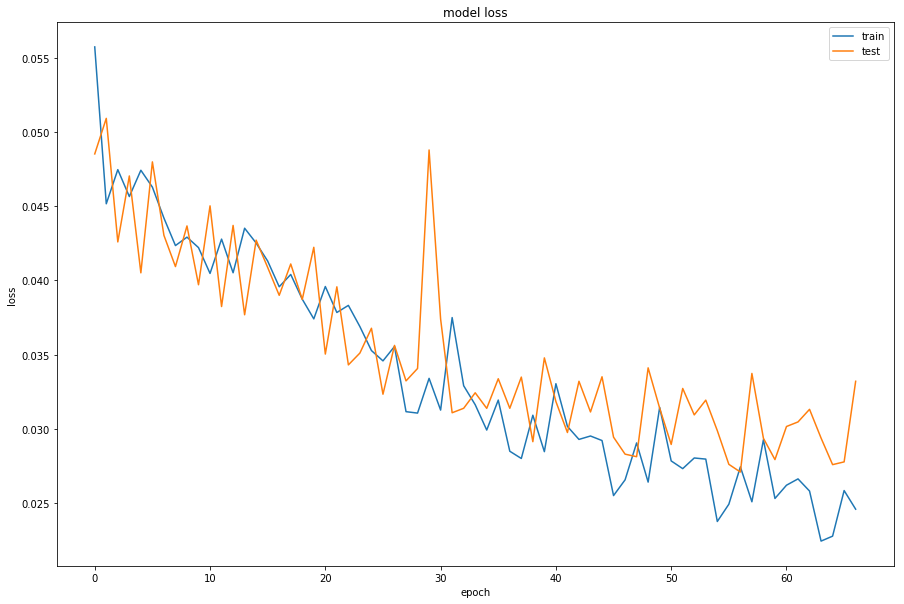

In [240]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [185]:
model.save("./best_tcn.h5")

#### Model 2 - 1D Convolutional network

In [237]:
# NOT USED

In [195]:
## Modeling paramters

timesteps = None
input_dim = 300

# Network paramters

filter_maps_1 = 64
filter_maps_2 = 128
filter_maps_3 = 256

dense_1   = 256
dense_2   = 128 
dense_out = 1

kernel_1 = 8
kernel_2 = 6
kernel_3 = 4

In [ ]:
from keras.utils import to_categorical
from keras.layers import SimpleRNN, LSTM, GRU, Embedding, Dense, Input, RepeatVector
from keras.models import Sequential, Model, load_model
from keras.layers import TimeDistributed, Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, UpSampling1D
from keras.callbacks import EarlyStopping
from keras.layers import LeakyReLU, Reshape, Conv2DTranspose, Flatten, PReLU
from keras.layers.core import Activation
from keras import regularizers

# ====== Encoder ======
inputs = Input(batch_shape=(1, timesteps, input_dim))

## ---------------------------- CNN layer 1 ----------------------------
Class_net = Conv1D(filter_maps_1, kernel_size=kernel_1, strides=2, padding='same')(inputs)
Class_net = LeakyReLU()(Class_net)
#Class_net = PReLU()(Class_net)
#Class_net = Activation('relu')(Class_net)

## ---------------------------- CNN layer 2 ----------------------------
Class_net = Conv1D(filter_maps_2, kernel_size=kernel_2, strides=2, padding='same')(Class_net)
Class_net = LeakyReLU()(Class_net)
#Class_net = PReLU()(Class_net)
#Class_net = Activation('relu')(Class_net)

## ---------------------------- CNN layer 3 ----------------------------
Class_net = Conv1D(filter_maps_3, kernel_size=kernel_3, strides=2, padding='same')(Class_net)
Class_net = LeakyReLU()(Class_net)
#Class_net = PReLU()(Class_net)
#Class_net = Activation('relu')(Class_net)

Class_net = Flatten()(Class_net)

## ---------------------------- Dense layer 1 ----------------------------
Class_net = Dense(dense_1, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))(Class_net)
#Class_net = PReLU()(Class_net)
#Class_net = LeakyReLU()(Class_net)
#Class_net = Activation('relu')(Class_net)
#Class_net = BatchNormalization()(Class_net)
#Class_net = Dropout(0.1)(Class_net)

Class_net = Dense(dense_out, activation='sigmoid')(Class_net)

In [217]:
class_net_model = Model(inputs,Class_net)
class_net_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        (1, None, 300)            0         
_________________________________________________________________
conv1d_617 (Conv1D)          (1, None, 64)             153664    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (1, None, 64)             0         
_________________________________________________________________
conv1d_618 (Conv1D)          (1, None, 128)            49280     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (1, None, 128)            0         
_________________________________________________________________
conv1d_619 (Conv1D)          (1, None, 256)            131328    
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (1, None, 256)            0         
Total para

In [218]:
adam = Adam(lr=0.0001)
class_net_model.compile(adam, loss='mean_squared_error')

In [219]:
checkpoint = ModelCheckpoint('./models/model-cnn-{epoch:03d}.h5', verbose=0, monitor='val_loss', save_best_only=True, mode='min')
stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')

In [220]:
epochs = 100

from itertools import cycle
train_data = cycle(zip(X_train, y_train))
validation_data = cycle(zip(X_test, y_test))

In [ ]:
history = class_net_model.fit_generator(iter(train_data), epochs=epochs, steps_per_epoch=1000, max_queue_size=1, validation_data=iter(validation_data), validation_steps=500, callbacks=[checkpoint, stopping])

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
model.save("./best_cnn.h5")